In [41]:
import scanpy as sc 
import numpy as np
import pandas as pd
import scanpy.external as sce
from collections import Counter

In [5]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    sc.tl.rank_genes_groups(adata, groupby="leiden")
    return(adata)

In [6]:
%%time
adata = sc.read_h5ad("01_Sim_adata.h5ad")
adata

CPU times: user 260 ms, sys: 1.84 s, total: 2.1 s
Wall time: 2.1 s


AnnData object with n_obs × n_vars = 54140 × 33939
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease'
    layers: 'counts'

### Filter to postnatal ND

In [7]:
adata = adata[adata.obs.age_status == "Postnatal", :].copy()
adata

AnnData object with n_obs × n_vars = 26380 × 33939
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease'
    layers: 'counts'

### Perform preprocessing

In [8]:
# store the raw counts
adata.layers["counts"] = adata.X

In [9]:
# perform initial filtering
sc.pp.filter_genes(adata, min_cells = 5)
sc.pp.filter_cells(adata, min_genes = 200)

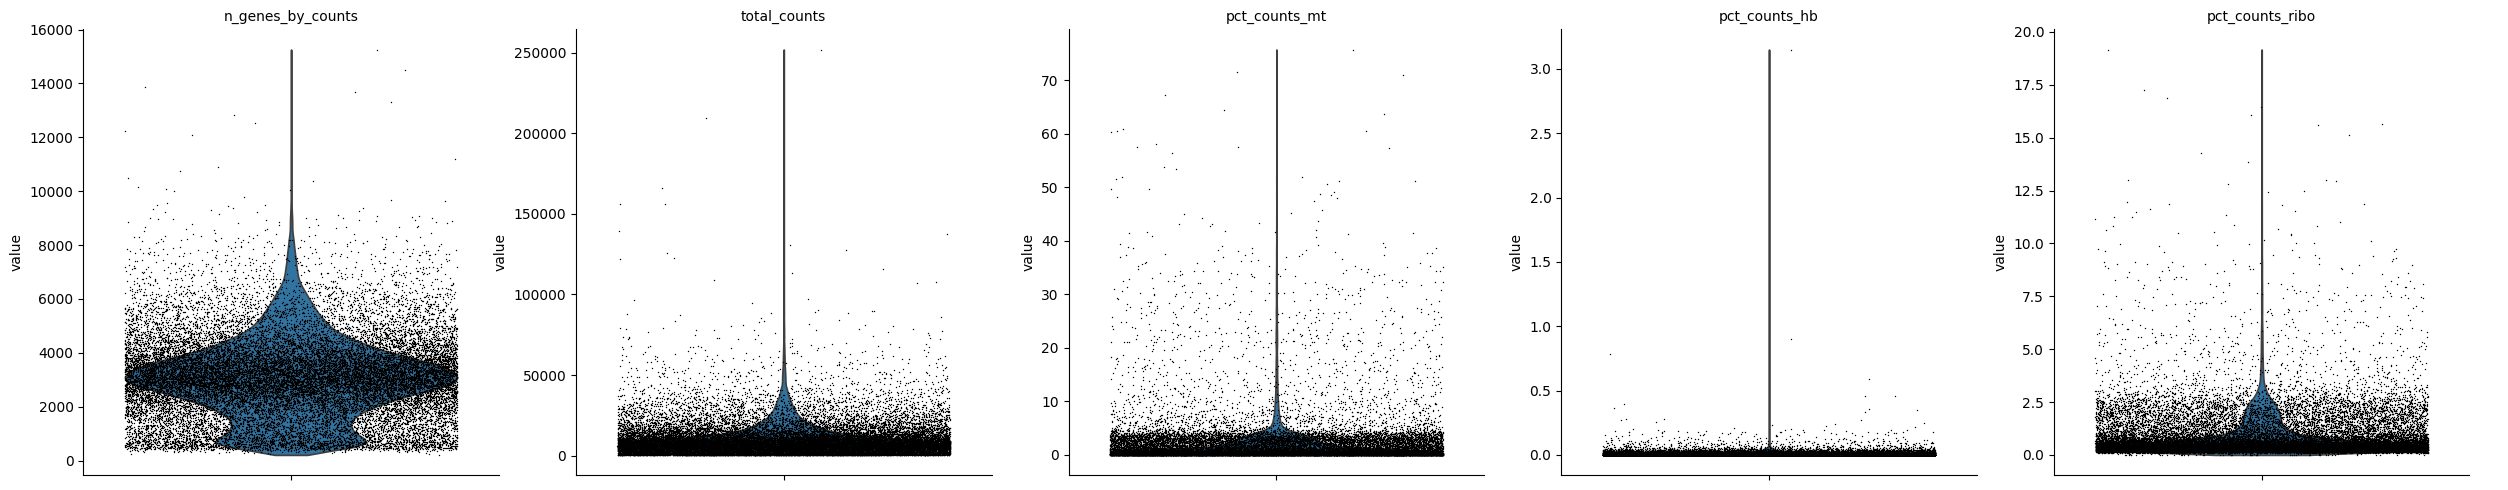

Filtered out 585 cells
CPU times: user 18.4 s, sys: 17.2 s, total: 35.6 s
Wall time: 4.89 s


In [10]:
%%time
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 15.0
ribo_threshold = 15.0
hb_threshold = 5.0

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [11]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
print("Performing scrublet analysis...")
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Performing scrublet analysis...
Filtered out 451 likely doublets
CPU times: user 10min 5s, sys: 11min 41s, total: 21min 46s
Wall time: 3min 1s


Running the preprocessing and leiden clustering...


2024-11-23 19:42:35,351 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 19:42:38,060 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 19:42:38,158 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 19:42:44,328 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 19:42:50,207 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 19:42:55,951 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 19:43:01,718 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 19:43:07,449 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 19:43:13,317 - harmonypy - INFO - Converged after 6 iterations


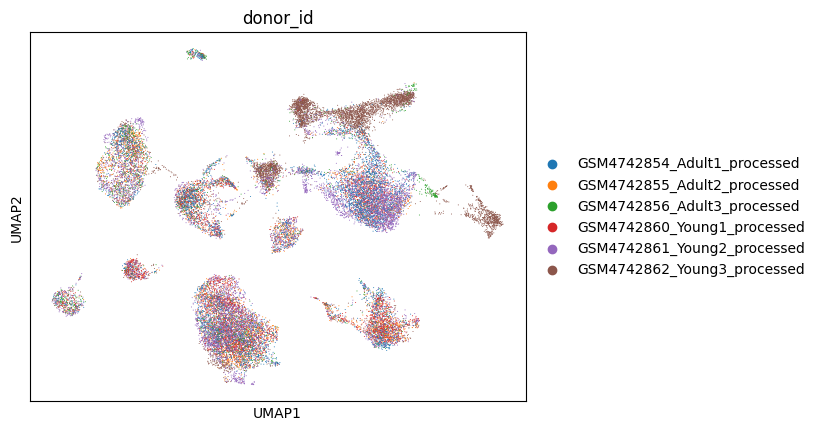

CPU times: user 11min 24s, sys: 37min 46s, total: 49min 10s
Wall time: 1min 17s


In [12]:
%%time
print("Running the preprocessing and leiden clustering...", flush=True)
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata,
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

### Identify differentially expressed genes

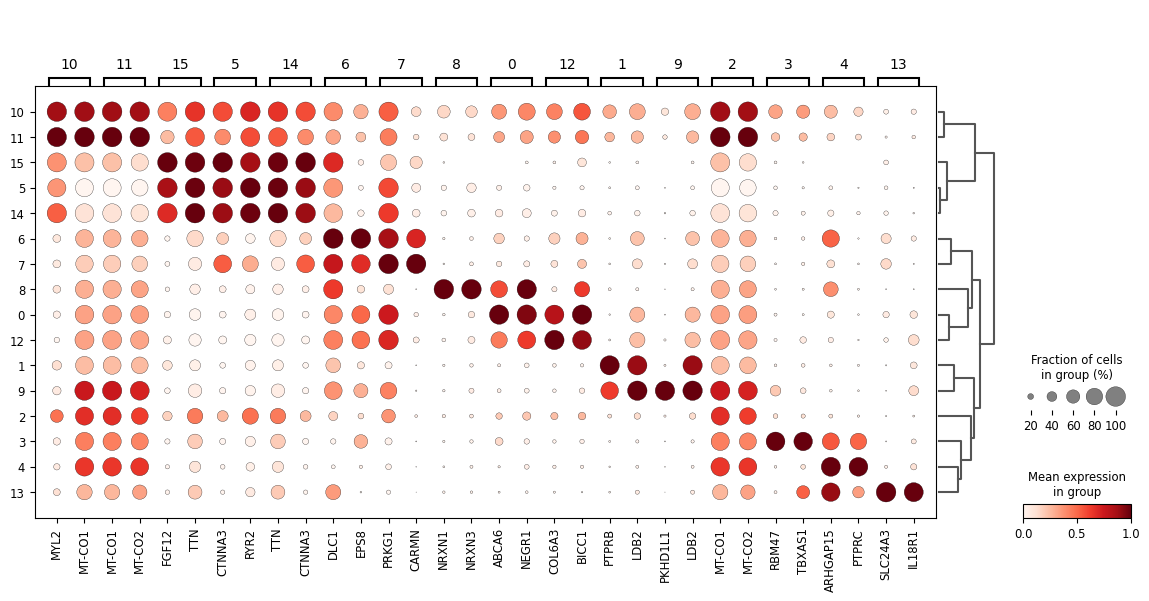

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=2)

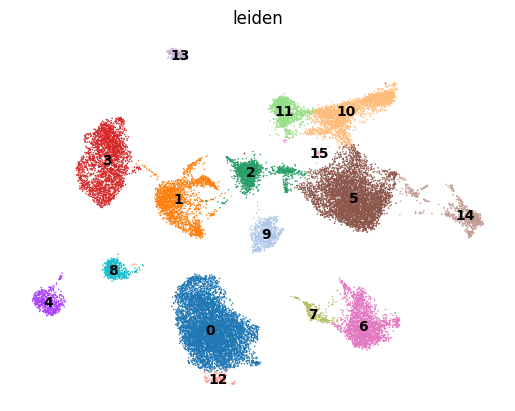

In [15]:
sc.pl.umap(adata,color=["leiden"], legend_loc="on data",frameon=False)

In [38]:
sc.get.rank_genes_groups_df(adata, group="15").head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,FGF12,64.473984,5.196678,3.110035e-31,1.375117e-30
1,TTN,41.399021,4.061669,9.051209e-26,3.663334e-25
2,MTUS2,40.914864,5.273424,1.291072e-24,5.118783e-24
3,SLC8A1,39.465134,5.069469,1.694529e-24,6.704043e-24
4,CTNNA3,38.295307,4.325185,2.223804e-24,8.785496e-24
5,FHOD3,36.458717,4.245139,1.308226e-23,5.092331e-23
6,LDB3,32.359455,3.286515,1.711200e-22,6.513107e-22
7,CACNA1C,32.210125,3.496211,2.072346e-22,7.873667e-22
8,LARGE1,29.165833,3.394168,4.458871e-21,1.650543e-20
9,SORBS2,25.940117,3.942756,7.219165e-20,2.603979e-19


In [39]:
adata.obs["cell_type"] = adata.obs["leiden"].map(
    {
        "0": "Fibroblast",
        "1": "Endothelial",
        "2": "High-mito",
        "3": "Myeloid",
        "4": "Lymphoid",
        "5": "Cardiomyocyte",
        "6": "Pericyte",
        "7": "vSMC",
        "8": "Neuronal",
        "9": "Endocardial",
        "10": "High-mito",
        "11": "High-mito",
        "12": "Fibroblast",
        "13": "Mast",
        "14": "Unclear",
        "15": "Cardiomyocyte"
    }
)

In [42]:
Counter(adata.obs["cell_type"])

Counter({'Fibroblast': 6433,
         'Cardiomyocyte': 4812,
         'High-mito': 4788,
         'Myeloid': 2410,
         'Pericyte': 2043,
         'Endothelial': 1935,
         'Unclear': 790,
         'Endocardial': 673,
         'Lymphoid': 525,
         'Neuronal': 512,
         'vSMC': 238,
         'Mast': 184})

In [43]:
# since we annotated it, copy over the cell_type to consistent_cell_type
adata.obs["consistent_cell_type"] = adata.obs["cell_type"]

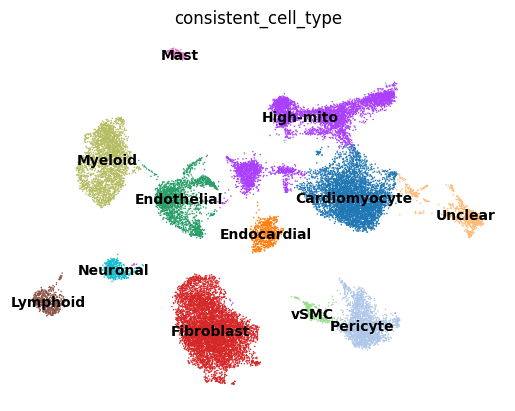

In [44]:
sc.pl.umap(adata,color=["consistent_cell_type"], legend_loc="on data",frameon=False)

In [45]:
# restore the raw counts
adata.X = adata.layers["counts"]

In [46]:
%%time
# remove the high-mito clusters and RBC
adata = adata[~adata.obs.cell_type.isin(["High-mito", "RBC"]), :].copy()
adata

CPU times: user 501 ms, sys: 615 ms, total: 1.12 s
Wall time: 1.12 s


AnnData object with n_obs × n_vars = 20555 × 27785
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'leiden', 'cell_type', 'consistent_cell_type'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'

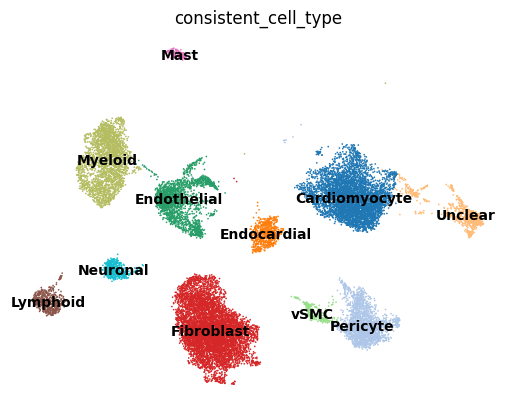

In [47]:
sc.pl.umap(adata, color=["consistent_cell_type"], legend_loc="on data",frameon=False)

In [50]:
Counter(adata.obs_names).most_common()[0]

('GSM4742855_Adult2_processed:AAACCCAAGATCGACG-1', 1)

In [48]:
adata.write("02_Sim_ND.h5ad")